# Bitcoin Market Predictor

Predicting BTCUSD market with a recurrent neural network

# Currency Market Predictor - Deep Regressor

Predicting BTCUSD market

In [3]:
import tensorflow as tf
from tensorflow.contrib import rnn
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Read data

In [4]:
import pickle

dataset = pickle.load( open( "dataset.p", "rb" ) )

In [ ]:
dataset = pd.read_csv('data/coinbaseUSD_1-min_data_2014-12-01_to_2017-10-20.csv')
dataset.head(10)

In [ ]:
dataset.tail(10)

In [ ]:
# Make the neural net happy with the inputs: zero mean, -1 to 1
# only about 0.1% of high jumps in volume are clipped.

dataset['Weighted_Price_PCT'] = dataset['Weighted_Price'].pct_change().fillna(0)
dataset['Weighted_Price_PCT'] = dataset['Weighted_Price_PCT']*50
dataset['Weighted_Price_PCT'] = dataset['Weighted_Price_PCT'].clip(-1,1)

dataset['Weighted_Price_rolling_5'] = dataset['Weighted_Price_PCT'].rolling(5, win_type='blackmanharris').mean()
dataset['Weighted_Price_rolling_15'] = dataset['Weighted_Price_PCT'].rolling(15, win_type='blackmanharris').mean()
dataset['Weighted_Price_rolling_60'] = dataset['Weighted_Price_PCT'].rolling(60, win_type='blackmanharris').mean()*2
dataset['Weighted_Price_rolling_180'] = dataset['Weighted_Price_PCT'].rolling(180, win_type='blackmanharris').mean()*3
dataset['Weighted_Price_rolling_720'] = dataset['Weighted_Price_PCT'].rolling(720, win_type='blackmanharris').mean()*6
dataset['Weighted_Price_rolling_2880'] = dataset['Weighted_Price_PCT'].rolling(2880, win_type='blackmanharris').mean()*12
dataset['Weighted_Price_rolling_10080'] = dataset['Weighted_Price_PCT'].rolling(10080, win_type='blackmanharris').mean()*200

In [ ]:
dataset['Volume_PCT'] = dataset['Volume_(BTC)'].pct_change(periods=10).fillna(0)
dataset['Volume_PCT'] = dataset['Volume_PCT'] + 1
dataset['Volume_PCT'] = np.clip(np.log(dataset['Volume_PCT'])/30, -1,1)
        
dataset['Volume_PCT_rolling_5'] = dataset['Volume_PCT'].rolling(5, win_type='blackmanharris').mean()*1.5
dataset['Volume_PCT_rolling_15'] = dataset['Volume_PCT'].rolling(15, win_type='blackmanharris').mean()*2.5
dataset['Volume_PCT_rolling_60'] = dataset['Volume_PCT'].rolling(60, win_type='blackmanharris').mean()*6
dataset['Volume_PCT_rolling_180'] = dataset['Volume_PCT'].rolling(180, win_type='blackmanharris').mean()*20
dataset['Volume_PCT_rolling_720'] = dataset['Volume_PCT'].rolling(720, win_type='blackmanharris').mean()*60
dataset['Volume_PCT_rolling_2880'] = dataset['Volume_PCT'].rolling(2880, win_type='blackmanharris').mean()*250
dataset['Volume_PCT_rolling_10080'] = dataset['Volume_PCT'].rolling(10080, win_type='blackmanharris').mean()*3000

In [ ]:
import pickle

pickle.dump( dataset, open( "dataset.p", "wb" ) )

In [ ]:
plt.figure(figsize=(16,20))
plt.subplot(8,1,1)
n, bins, patches = plt.hist(dataset['Weighted_Price_PCT'].iloc[-100000:], 200)
plt.xlim(-1, 1)
plt.subplot(8,1,2)
n, bins, patches = plt.hist(dataset['Weighted_Price_rolling_5'].iloc[-100000:], 200)
plt.xlim(-1, 1)
plt.subplot(8,1,3)
n, bins, patches = plt.hist(dataset['Weighted_Price_rolling_15'].iloc[-100000:], 200)
plt.xlim(-1, 1)
plt.subplot(8,1,4)
n, bins, patches = plt.hist(dataset['Weighted_Price_rolling_60'].iloc[-100000:], 200)
plt.xlim(-1, 1)
plt.subplot(8,1,5)
n, bins, patches = plt.hist(dataset['Weighted_Price_rolling_180'].iloc[-100000:], 200)
plt.xlim(-1, 1)
plt.subplot(8,1,6)
n, bins, patches = plt.hist(dataset['Weighted_Price_rolling_720'].iloc[-100000:], 200)
plt.xlim(-1, 1)
plt.subplot(8,1,7)
n, bins, patches = plt.hist(dataset['Weighted_Price_rolling_2880'].iloc[-100000:], 200)
plt.xlim(-1, 1)
plt.subplot(8,1,8)
n, bins, patches = plt.hist(dataset['Weighted_Price_rolling_10080'].iloc[-100000:], 200)
plt.xlim(-1, 1)

(-1, 1)

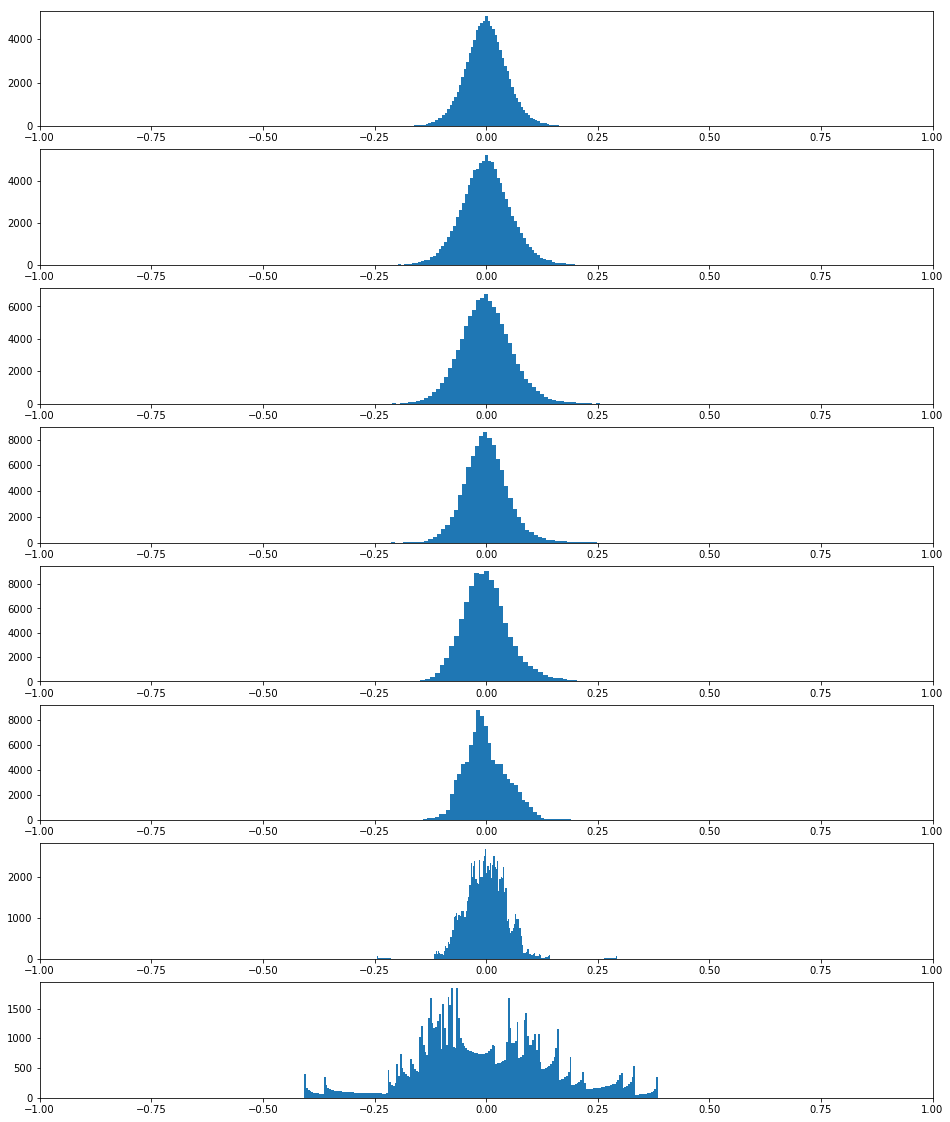

In [6]:
plt.figure(figsize=(16,20))
plt.subplot(8,1,1)
n, bins, patches = plt.hist(dataset['Volume_PCT'].iloc[-100000:], 200)
plt.xlim(-1, 1)
plt.subplot(8,1,2)
n, bins, patches = plt.hist(dataset['Volume_PCT_rolling_5'].iloc[-100000:], 200)
plt.xlim(-1, 1)
plt.subplot(8,1,3)
n, bins, patches = plt.hist(dataset['Volume_PCT_rolling_15'].iloc[-100000:], 200)
plt.xlim(-1, 1)
plt.subplot(8,1,4)
n, bins, patches = plt.hist(dataset['Volume_PCT_rolling_60'].iloc[-100000:], 200)
plt.xlim(-1, 1)
plt.subplot(8,1,5)
n, bins, patches = plt.hist(dataset['Volume_PCT_rolling_180'].iloc[-100000:], 200)
plt.xlim(-1, 1)
plt.subplot(8,1,6)
n, bins, patches = plt.hist(dataset['Volume_PCT_rolling_720'].iloc[-100000:], 200)
plt.xlim(-1, 1)
plt.subplot(8,1,7)
n, bins, patches = plt.hist(dataset['Volume_PCT_rolling_2880'].iloc[-100000:], 200)
plt.xlim(-1, 1)
plt.subplot(8,1,8)
n, bins, patches = plt.hist(dataset['Volume_PCT_rolling_10080'].iloc[-100000:], 200)
plt.xlim(-1, 1)


In [ ]:
dataset.head(10)

In [ ]:
dataset.tail(10)

In [7]:
list(dataset)

['Timestamp',
 'Open',
 'High',
 'Low',
 'Close',
 'Volume_(BTC)',
 'Volume_(Currency)',
 'Weighted_Price',
 'Weighted_Price_PCT',
 'Weighted_Price_rolling_5',
 'Weighted_Price_rolling_15',
 'Weighted_Price_rolling_60',
 'Weighted_Price_rolling_180',
 'Weighted_Price_rolling_720',
 'Weighted_Price_rolling_2880',
 'Weighted_Price_rolling_10080',
 'Volume_PCT',
 'Volume_PCT_rolling_5',
 'Volume_PCT_rolling_15',
 'Volume_PCT_rolling_60',
 'Volume_PCT_rolling_180',
 'Volume_PCT_rolling_720',
 'Volume_PCT_rolling_2880',
 'Volume_PCT_rolling_10080']

In [ ]:
len(dataset['Weighted_Price_rolling_5'])

In [13]:
OFFSET = 5

SAMPLES = 1400000

input_data = dataset[['Weighted_Price_rolling_5', 'Weighted_Price_rolling_15', 'Weighted_Price_rolling_60', 
                      'Weighted_Price_rolling_180', 'Weighted_Price_rolling_720', 'Weighted_Price_rolling_2880',
                     'Weighted_Price_rolling_10080', 'Volume_PCT_rolling_5', 'Volume_PCT_rolling_15',
                     'Volume_PCT_rolling_60', 'Volume_PCT_rolling_180', 'Volume_PCT_rolling_720', 
                     'Volume_PCT_rolling_2880', 'Volume_PCT_rolling_10080']].iloc[-SAMPLES:-OFFSET] # about 2 years of data
target_data = dataset['Weighted_Price_rolling_15'].iloc[-(SAMPLES-OFFSET):]

# split data into test and validation data
prediction_mins = 18000 # 5 days 
training_input = input_data[:len(input_data)-prediction_mins]
training_input = np.expand_dims(training_input, axis=1)

validation_input = input_data[-prediction_mins:]
validation_input = np.expand_dims(validation_input, axis=1)

training_target = target_data[:len(target_data)-prediction_mins]
validation_target = target_data[-prediction_mins:]

In [9]:
# Importing the Keras libraries and packages
from keras.models import Sequential, load_model
from keras.layers import LSTM, GRU, Dropout, Dense, GRUCell
from keras.callbacks import ModelCheckpoint, EarlyStopping

from numpy.testing import assert_allclose

Using TensorFlow backend.


In [10]:
# load the model
regressor = load_model("regressor.h5")
#assert_allclose(regressor.predict(X_train), new_model.predict(X_train), 1e-5)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

# Initialising the RNN
regressor = Sequential()

# Adding the input layer and the LSTM layer
regressor.add(GRU(2048, return_sequences=True, input_shape = (None, 14)))

# Adding the input layer and the LSTM layer
regressor.add(GRU(units = 512, input_shape = (None, 256)))

# Adding the output layer
regressor.add(Dense(64, activation='tanh'))

# Adding the output layer
regressor.add(Dense(16, activation='tanh'))

# Adding the output layer
regressor.add(Dense(1, activation='linear'))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# define the checkpoint
filepath = "regressor.h5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]


In [ ]:
# Fitting the RNN to the Training set
regressor.fit(training_input, training_target, batch_size = 512, epochs = 400, validation_split=0.2, callbacks=[checkpoint])

In [ ]:
# fit the model
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
new_model.fit(X_train, Y_train, epochs=5, batch_size=50, callbacks=callbacks_[checkpoint])

In [14]:
# Making the predictions

#X_test = validation_input[0:-20]
#Y_test = validation_target[20:]

#X_test = np.expand_dims(X_test, axis=1)


#test_set = validation_input[0:len(validation_input)-60]
#test_set = np.expand_dims(test_set, axis=1)
#inputs = np.reshape(test_set, (len(test_set), 1, 1))
predicted_BTC_price = regressor.predict(validation_input)


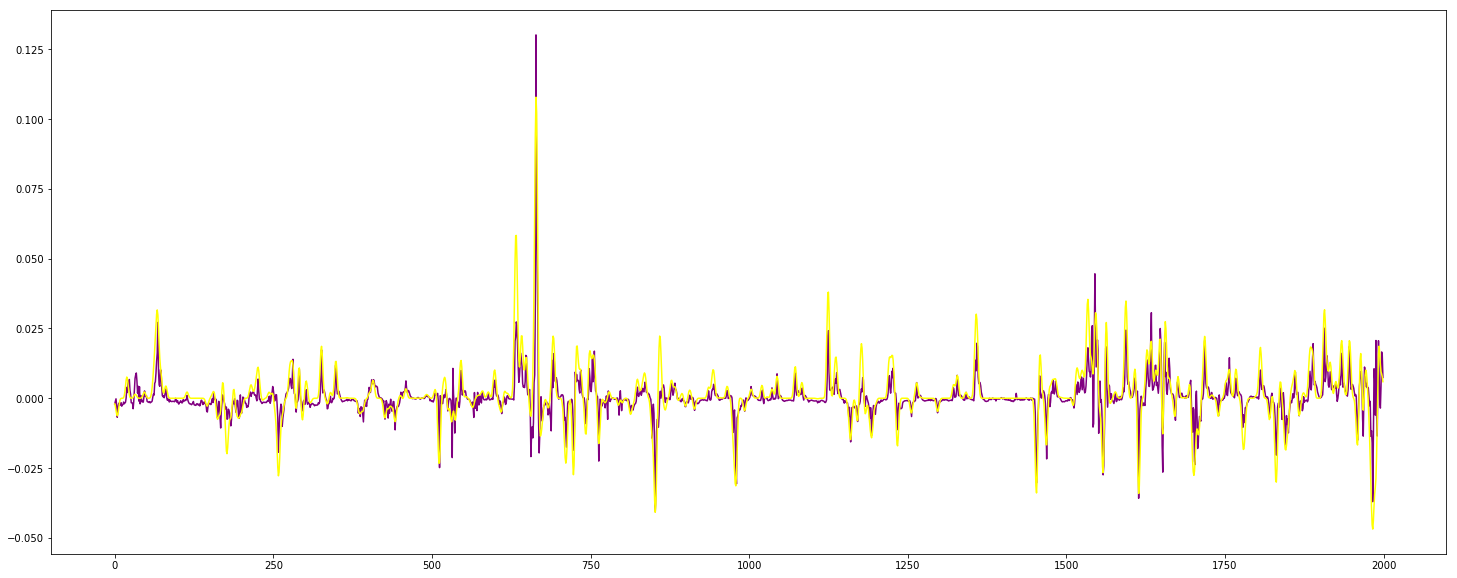

In [15]:
plt.figure(figsize=(25,10))
plt.plot(predicted_BTC_price[:2000], color = 'purple')
#plt.plot(X_test[270:800,0,:-1])
plt.plot(validation_target.values[:2000], color = 'yellow')

In [ ]:
plt.figure(figsize=(25,10))
plt.plot(predicted_BTC_price[:2000], color = 'purple')
#plt.plot(X_test[270:800,0,:-1])
plt.plot(validation_target.values[:2000], color = 'yellow')

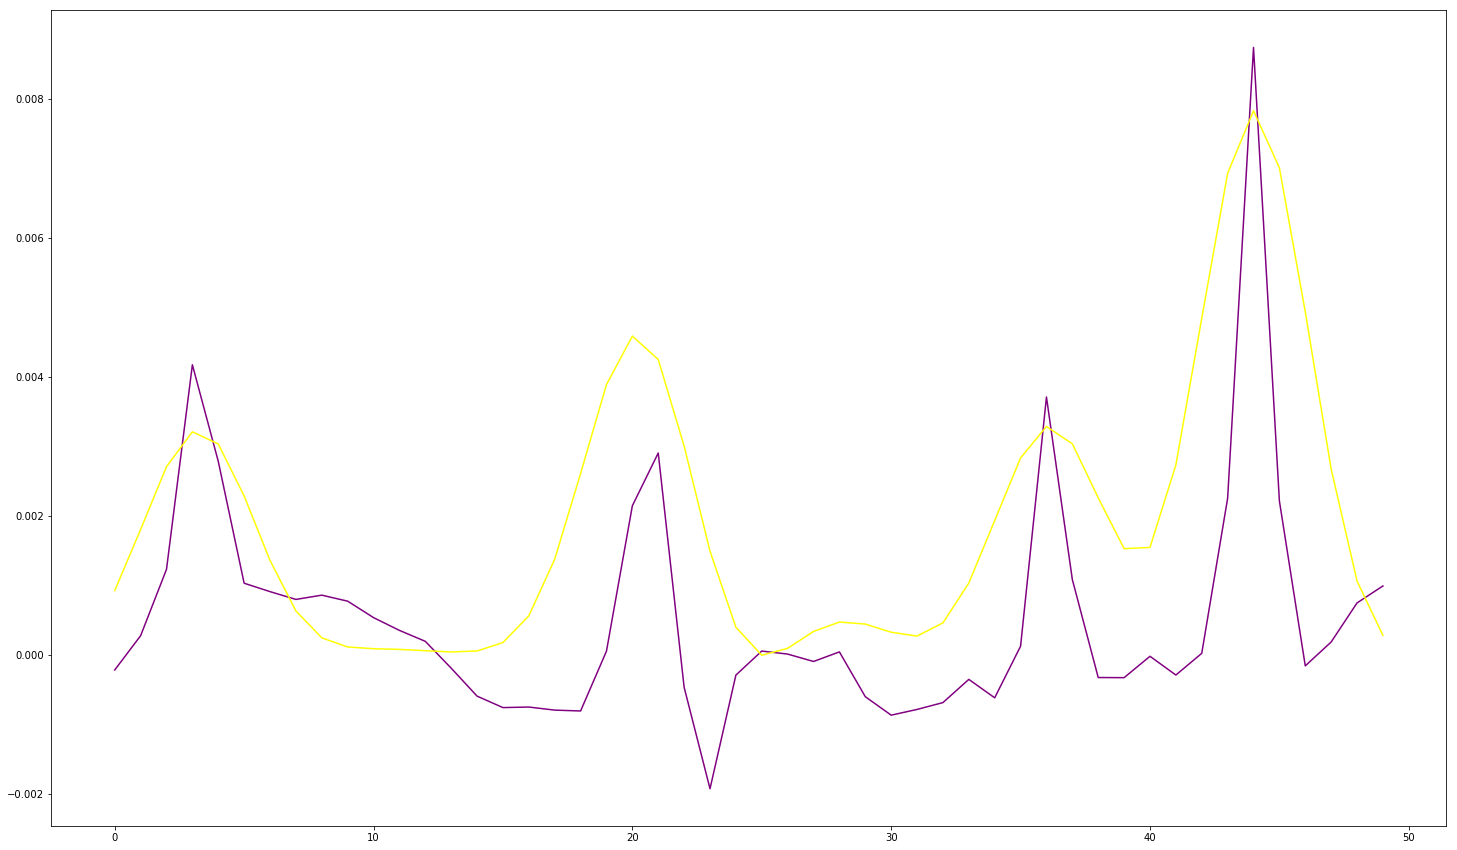

In [24]:
plt.figure(figsize=(25,15))
plt.plot(predicted_BTC_price[1000:1050], color = 'purple')
#plt.plot(validation_input[300:400,0,:])
plt.plot(validation_target.values[1000:1050], color = 'yellow')
#plt.ylim(0,0.05)

In [ ]:
input_data = dataset[['Weighted_Price_rolling_5', 'Weighted_Price_rolling_15', 'Weighted_Price_rolling_60', 
                      'Weighted_Price_rolling_180', 'Weighted_Price_rolling_720', 'Weighted_Price_rolling_2880',
                     'Weighted_Price_rolling_10080', 'Volume_PCT_rolling_5', 'Volume_PCT_rolling_15',
                     'Volume_PCT_rolling_60', 'Volume_PCT_rolling_180', 'Volume_PCT_rolling_720', 
                     'Volume_PCT_rolling_2880', 'Volume_PCT_rolling_10080']].iloc[-SAMPLES:-OFFSET] # about 2 years of data
target_data = dataset['Weighted_Price_rolling_15'].iloc[-(SAMPLES-OFFSET):]

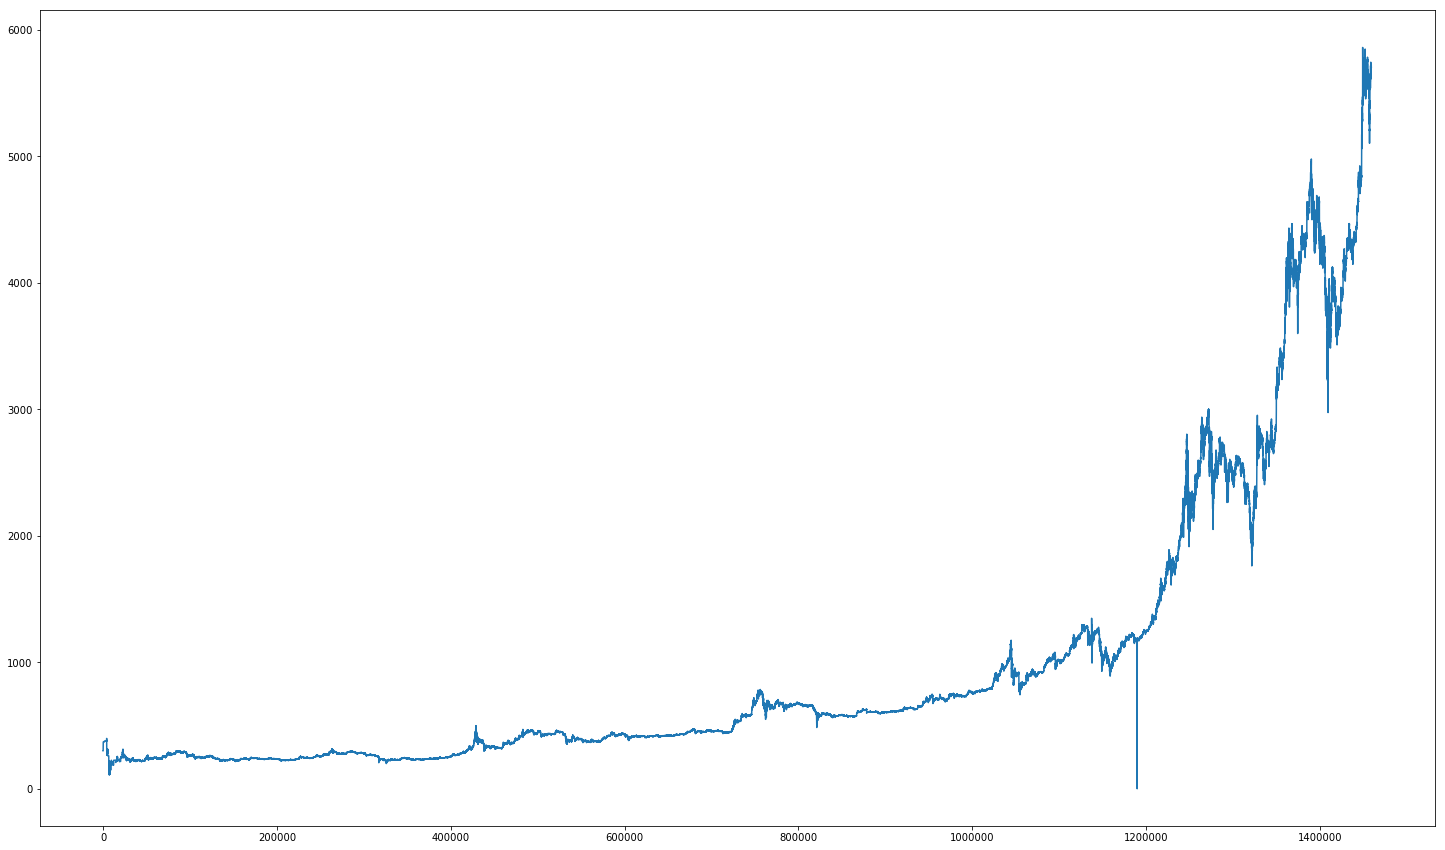

In [26]:
plt.figure(figsize=(25,15))
plt.plot(dataset['Weighted_Price'])

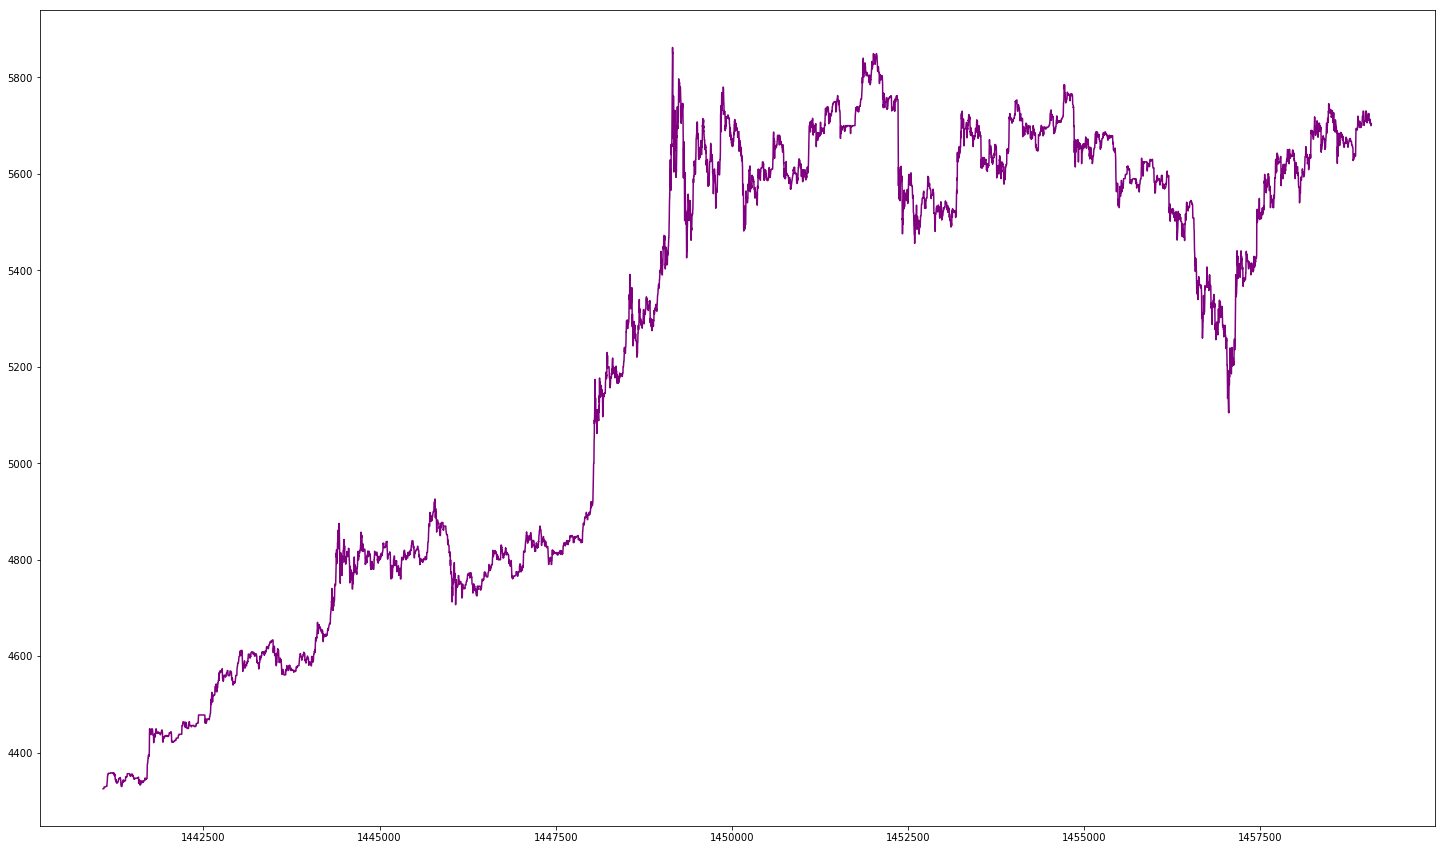

In [27]:
plt.figure(figsize=(25,15))
plt.plot(dataset['Weighted_Price'].iloc[-prediction_mins:], color = 'purple')

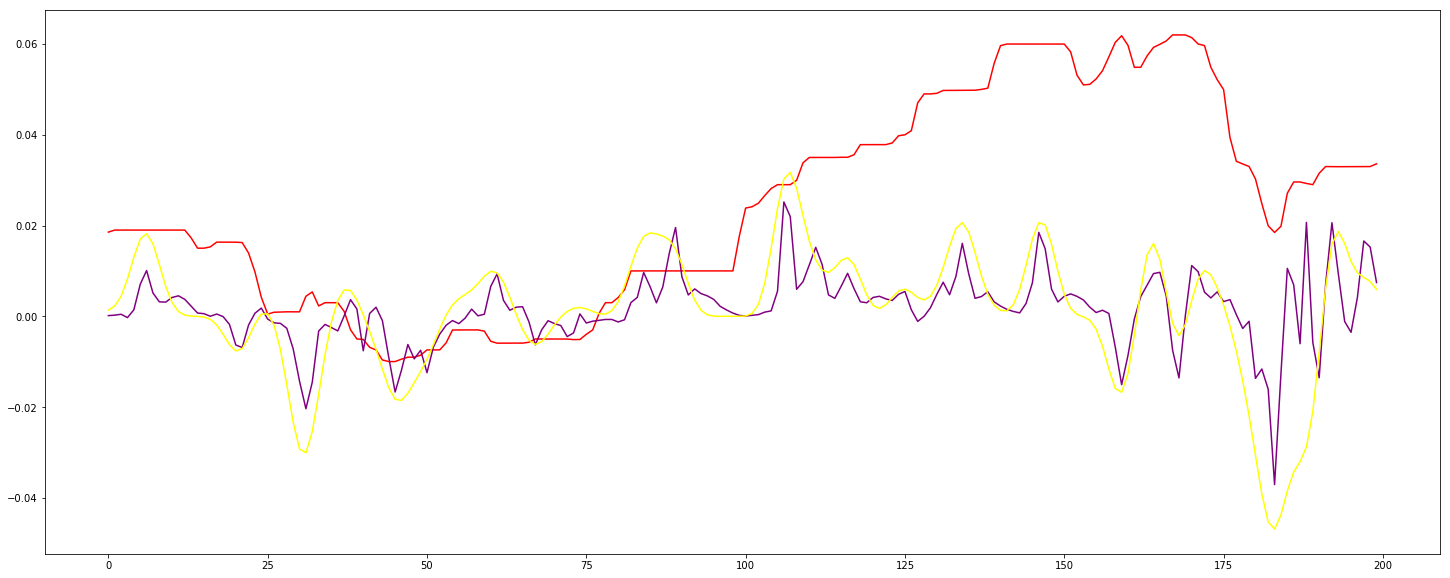

In [63]:
plt.figure(figsize=(25,10))
plt.plot(dataset['Weighted_Price'].iloc[-prediction_mins:].values[1800:2000]/1000-4.55, color = 'red')
plt.plot(predicted_BTC_price[1800:2000], color = 'purple')

plt.plot(validation_target.values[1800:2000], color = 'yellow')

In [54]:
low = 98368.004
mid = 26861.522
high = 8936.917

In [50]:
low = 2437
mid = 543.5
high = 189.8

In [46]:
low = 2437
mid = 643.5
high = 289.8

In [55]:
R1 = mid + (mid*(low + high)  - 2*high*low)/(high + low -2*mid)
R1

47841.75234434621

In [56]:
R2 = R1 - mid
R2

20980.23034434621

In [57]:
R3 = R1*(R1 + low - mid)/(low-mid)
R3

79850.50460512386